# 공통사항

## Import Library

In [40]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

## Data Load

In [2]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

## Data Preprocessing

In [3]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
# 데이터를 동일하게 처리해주기 유용함.
dt['is_test'] = 0
dt_test['is_test'] = 1
df = pd.concat([dt, dt_test])     # 하나의 데이터로 만들어줍니다.

In [4]:
# 필요 없어 보이는 columns 제거
drop_col = ['부번', '계약일', 'k-전화번호', 'k-팩스번호', 'k-관리방식', 'k-복도유형', 'k-시행사', 'k-사용검사일-사용승인일', 'k-홈페이지', 'k-등록일자', 'k-수정일자', '고용보험관리번호', '경비비관리형태', '세대전기계약방법', '청소비관리형태', '기타/의무/임대/임의=1/2/3/4', '단지승인일', '사용허가여부', '관리비 업로드', '단지신청일', 'k-관리비부과면적', '주차대수', '건축면적', '해제사유발생일', '단지소개기존clob', 'k-135㎡초과', '중개사소재지', '등기신청일자']
df.drop(drop_col, axis=1, inplace=True)

In [5]:
df['구'] = df['시군구'].apply(lambda x:x.split()[1])
df['동'] = df['시군구'].apply(lambda x:x.split()[2])

omg = ['용산구', '강남구', '서초구', '송파구', '성동구', '종로구']
is_omg = []
for x in df['구'].tolist():
    if x in omg:
        is_omg.append(1)
    else:
        is_omg.append(0)
df['개비싸'] = is_omg
# 이렇게 말고 '동' 을 분류하지 않아도 될듯       
df.loc[~df['구'].isin(omg), '동'] = 'Unknown' 

del df['시군구']

In [6]:
# 위 처럼 아무 의미도 갖지 않는 칼럼은 결측치와 같은 역할을 하므로, np.nan으로 채워 결측치로 인식되도록 합니다.
df['거래유형'] = df['거래유형'].replace('-', np.nan)

In [7]:
# 본번, 부번의 경우 float로 되어있지만 범주형 변수의 의미를 가지므로 object(string) 형태로 바꾸어주고 아래 작업을 진행하겠습니다.
df['본번'] = df['본번'].astype('str')

In [8]:
df['계약년'] = df['계약년월'].astype('str').map(lambda x : x[:4])
df['계약월'] = df['계약년월'].astype('str').map(lambda x : x[4:])

In [9]:
# 'time_col' 데이터를 문자열 형태로 변환
df['계약년월'] = df['계약년월'].astype(str)
# 문자열 형태 데이터를 datetime 형태로 변환
df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')
# 변환 확인
print(df['계약년월'].head())

0   2017-12-01
1   2017-12-01
2   2017-12-01
3   2018-01-01
4   2018-01-01
Name: 계약년월, dtype: datetime64[ns]


In [10]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y', 'target', 'is_test', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '계약년월', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [11]:
# 수치형 데이터를 어떻게 채워야 될지 모르겠음 -> 걍 빼.
# 좌표X, 좌표Y 를 리니어로 채우는건 혼동을 줄 수 있는 데이터임
df.drop(columns=['k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', '좌표X', '좌표Y'], inplace=True)

In [12]:
# 범주형 변수에 대한 보간
df[categorical_columns] = df[categorical_columns].fillna('NULL')

## Feature engineering

In [13]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 19) (9272, 19)


In [14]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
df_test['target'] = 0

In [15]:
# 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns_v2 = []
categorical_columns_v2 = []

for column in df_train.columns:
    if column == '계약년월':
        continue
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns_v2.append(column)
    else:
        categorical_columns_v2.append(column)

print("연속형 변수:", continuous_columns_v2)
print("범주형 변수:", categorical_columns_v2)

연속형 변수: ['전용면적(㎡)', '층', '건축년도', 'target', '개비싸']
범주형 변수: ['번지', '본번', '아파트명', '도로명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-난방방식', 'k-건설사(시공사)', '구', '동', '계약년', '계약월']


In [16]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns_v2 ):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 13/13 [00:03<00:00,  3.89it/s]


In [17]:
df_train.head()        # 레이블인코딩이 된 모습입니다.

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-난방방식,k-건설사(시공사),target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


# Model Training

https://gmnam.tistory.com/230

In [18]:
assert df_train.shape[1] == df_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [19]:
def preprocess_feature_name(feature_name):
  """특수 문자를 제거하고 소문자로 변환합니다."""
  feature_name = feature_name.replace("-", "_")
  feature_name = feature_name.replace(",", "_")
  feature_name = feature_name.replace(".", "_")
  feature_name = feature_name.replace("(", "_")
  feature_name = feature_name.replace(")", "_")
  feature_name = feature_name.lower()
  return feature_name

def apply_preprocessed_feature_names(df_train):
  """데이터 프레임의 feature 이름을 수정합니다."""
  df_train.columns = [preprocess_feature_name(feature) for feature in df_train.columns]
  return df_train

# 데이터 프레임에 적용
df_train = apply_preprocessed_feature_names(df_train.copy())
df_test = apply_preprocessed_feature_names(df_test.copy())

# 확인
print(df_train.columns)

Index(['번지', '본번', '아파트명', '전용면적_㎡_', '계약년월', '층', '건축년도', '도로명', '거래유형',
       'k_단지분류_아파트_주상복합등등_', 'k_세대타입_분양형태_', 'k_난방방식', 'k_건설사_시공사_', 'target',
       '구', '동', '개비싸', '계약년', '계약월'],
      dtype='object')


In [20]:
df_train.head()

,번지,본번,아파트명,전용면적_㎡_,계약년월,층,건축년도,도로명,거래유형,k_단지분류_아파트_주상복합등등_,k_세대타입_분양형태_,k_난방방식,k_건설사_시공사_,target,구,동,개비싸,계약년,계약월
0,4732,1149,328,79.97,2017-12-01,3,1987,6176,0,3,2,1,241,124000.0,0,3,1,10,11
1,4732,1149,328,79.97,2017-12-01,4,1987,6176,0,3,2,1,241,123500.0,0,3,1,10,11
2,4732,1149,328,54.98,2017-12-01,5,1987,6176,0,3,2,1,241,91500.0,0,3,1,10,11
3,4732,1149,328,79.97,2018-01-01,4,1987,6176,0,3,2,1,241,130000.0,0,3,1,11,0
4,4732,1149,328,79.97,2018-01-01,2,1987,6176,0,3,2,1,241,117000.0,0,3,1,11,0


In [36]:
# Holdout - Random
y_train = df_train['target']
X_train = df_train.drop(['target', '계약년월'], axis=1)

holdout_random_X_train, holdout_random_X_val, holdout_random_y_train, holdout_random_y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [37]:
gbm = lgb.LGBMRegressor(n_estimators=1000)
gbm.fit(holdout_random_X_train, holdout_random_y_train,
        eval_set=[(holdout_random_X_train, holdout_random_y_train), (holdout_random_X_val, holdout_random_y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=10),
                   lgb.log_evaluation(period=10, show_stdv=True)])

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1759
[LightGBM] [Info] Number of data points in the train set: 895057, number of used features: 17
[LightGBM] [Info] Start training from score 58000.483999
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 27029.5	training's l2: 7.30595e+08	valid_1's rmse: 27305.8	valid_1's l2: 7.45608e+08
[20]	training's rmse: 20590.9	training's l2: 4.23986e+08	valid_1's rmse: 20889.8	valid_1's l2: 4.36385e+08
[30]	training's rmse: 17710.6	training's l2: 3.13664e+08	valid_1's rmse: 18041.2	valid_1's l2: 3.25485e+08
[40]	training's rmse: 16163.6	training's l2: 2.61261e+08	valid_1's rmse: 16501.7	valid_1's l2: 2.72308e+08
[50]	training's rmse: 15126.5	training's l2: 2.2881e+08	valid_1's rmse: 15480.8	valid_1's l2: 2.39656e+08
[60]	training's rmse: 14424.6	training's l2: 2.0807e+08

LGBMRegressor(n_estimators=1000)

In [41]:
%%time
X_test = df_test.drop(['target', '계약년월'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = gbm.predict(X_test)


CPU times: user 431 ms, sys: 0 ns, total: 431 ms
Wall time: 52.4 ms


In [42]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

---

In [24]:
# Holdout - 시간순서
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# 'date' 기준으로 데이터 정렬
df_train = df_train.sort_values('계약년월')

# 전체 데이터 길이의 20%를 검증 세트 크기로 사용
validation_size = int(len(df_train) * 0.2)

# 훈련 세트와 검증 세트로 분할
train_df = df_train[:-validation_size]
validation_df = df_train[-validation_size:]

holdout_X_train = train_df.drop(['target'], axis=1)
holdout_y_train = train_df['target']

holdout_X_val = validation_df.drop(['target'], axis=1)
holdout_y_val = validation_df['target']




In [25]:
print(f"Train set Date Range :")
display(holdout_X_train['계약년월'].sort_values(ascending=True).head().to_list())
print('...')
display(holdout_X_train['계약년월'].sort_values(ascending=False).head().to_list())

print(f"Valid set Date Range :")
display(holdout_X_val['계약년월'].sort_values(ascending=True).head().to_list())
print('...')
display(holdout_X_val['계약년월'].sort_values(ascending=False).head().to_list())

# 이제 train_df와 validation_df를 사용하여 모델 훈련 및 검증을 진행할 수 있습니다.
del holdout_X_train['계약년월']
del holdout_X_val['계약년월']

Train set Date Range :


[Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00'),
 Timestamp('2007-01-01 00:00:00')]

...


[Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00')]

Valid set Date Range :


[Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00')]

...


[Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00'),
 Timestamp('2023-06-01 00:00:00')]

In [27]:
gbm = lgb.LGBMRegressor(n_estimators=1000)
gbm.fit(holdout_X_train, holdout_y_train,
        eval_set=[(holdout_X_train, holdout_y_train), (holdout_X_val, holdout_y_val)],
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=10),
                   lgb.log_evaluation(period=10, show_stdv=True)])

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1745
[LightGBM] [Info] Number of data points in the train set: 895058, number of used features: 16
[LightGBM] [Info] Start training from score 49879.244612
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 20658.3	training's l2: 4.26764e+08	valid_1's rmse: 58851.1	valid_1's l2: 3.46346e+09
[20]	training's rmse: 15733.8	training's l2: 2.47554e+08	valid_1's rmse: 51159.1	valid_1's l2: 2.61725e+09
[30]	training's rmse: 13670.6	training's l2: 1.86886e+08	valid_1's rmse: 46216.5	valid_1's l2: 2.13597e+09
[40]	training's rmse: 12551.4	training's l2: 1.57539e+08	valid_1's rmse: 43187.3	valid_1's l2: 1.86514e+09
[50]	training's rmse: 11796.4	training's l2: 1.39154e+08	valid_1's rmse: 41033.7	valid_1's l2: 1.

LGBMRegressor(n_estimators=1000)

In [28]:
%%time
X_test = df_test.drop(['target', '계약년월'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = gbm.predict(X_test)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

CPU times: user 401 ms, sys: 352 µs, total: 402 ms
Wall time: 48.2 ms


- holdout 에서 시간순서로 했을 때 rmse 가 엄청나게 오름
    - 또한, train 단계에서는 overfitting 되는 것을 보임

In [33]:
# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        print(f"Fold {ii} :")
        print(f"  Train : index={tr[:5]}...")
        print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

In [42]:
# TimeSeriesSplit 함수를 선언합니다.
kf = TimeSeriesSplit(n_splits=5)

In [43]:
X_train = df_train.drop(['target'], axis=1)
Y_train = df_train['target']

X_train = X_train.sort_values(by='계약년월') # 시간순으로 정렬합니다.
Y_train = Y_train.reindex(X_train.index) # 정렬된 X_train의 인덱스에 맞추어 Y_train도 정렬해줍니다.

X_train = X_train.reset_index(drop=True) # 인덱스를 재정렬 해줍니다.
Y_train = Y_train.reset_index(drop=True)

del X_train['계약년월'] # 시간에 대한 정보를 지웁니다.

Fold 0 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[186472 186473 186474 186475 186476]...
Fold 1 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[372942 372943 372944 372945 372946]...
Fold 2 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[559412 559413 559414 559415 559416]...
Fold 3 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[745882 745883 745884 745885 745886]...
Fold 4 :
  Train : index=[0 1 2 3 4]...
  Valid : index=[932352 932353 932354 932355 932356]...


<Axes: title={'center': 'Time-Series K-Fold'}, xlabel='Sample index', ylabel='CV iteration'>

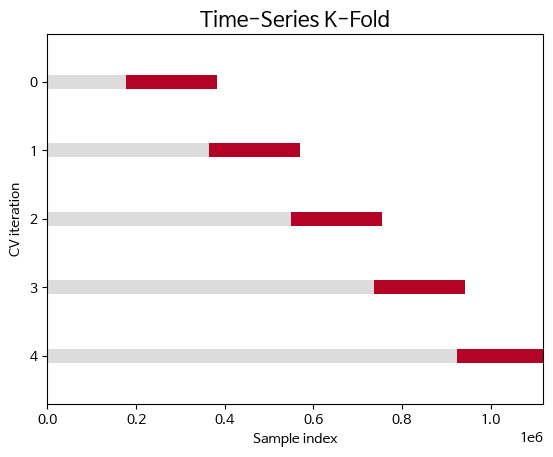

In [44]:
# TimeSeriesSplit를 시각화합니다.
fig, ax = plt.subplots()
plot_cv_indices(x=X_train,
                y=Y_train,
                cv=kf,
                ax=ax,
                split_strategy='Time-Series K-Fold')

In [49]:
# 학습 데이터를 TimeSeriesSplit로 나눕니다.
train_folds = kf.split(X_train, Y_train)
display(train_folds)

<generator object TimeSeriesSplit.split at 0x7f9517cabdf0>

In [50]:
%%time
fold_save_files = []
# 학습을 진행합니다.
for fold_idx, (train_idx, valid_idx) in enumerate(train_folds):
    display(f"--------{fold_idx}번째 fold의 학습을 시작합니다.--------")

    # index를 통해 fold의 학습세트를 가져옵니다.
    X_train_fold = X_train.iloc[train_idx, :]
    Y_train_fold = Y_train[train_idx]

    # index를 통해 fold의 평가세트를 가져옵니다.
    X_valid_fold = X_train.iloc[valid_idx, :]
    Y_valid_fold = Y_train[valid_idx]

    # fold의 데이터로 학습을 진행합니다.
    gbm = lgb.LGBMRegressor(n_estimators=1000)
    gbm.fit(X_train_fold, Y_train_fold,                                               # 학습 데이터를 입력합니다.
        eval_set=[(X_train_fold, Y_train_fold), (X_valid_fold, Y_valid_fold)], # 평가셋을 지정합니다.
        eval_metric ='rmse',                                                               # 평가과정에서 사용할 평가함수를 지정합니다.
        callbacks=[lgb.early_stopping(stopping_rounds=10),                                  # 10번의 성능향상이 없을 경우, 학습을 멈춥니다.
                   lgb.log_evaluation(period=10, show_stdv=True)]                           # 매 iteration마다 학습결과를 출력합니다.
    )

    # 각 fold별 학습한 모델을 저장합니다.
    file_name = f"timeseries_fold{fold_idx}_gbm.pkl"
    joblib.dump(gbm, file_name)
    display(f"--------{fold_idx}번째 fold는 {file_name}에 저장되었습니다.--------\n\n")
    fold_save_files.append(file_name)

'--------0번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1790
[LightGBM] [Info] Number of data points in the train set: 186472, number of used features: 16
[LightGBM] [Info] Start training from score 41118.515359
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 16752.4	training's l2: 2.80641e+08	valid_1's rmse: 17871.9	valid_1's l2: 3.19406e+08
[20]	training's rmse: 12759.2	training's l2: 1.62797e+08	valid_1's rmse: 13858.8	valid_1's l2: 1.92065e+08
[30]	training's rmse: 11206.8	training's l2: 1.25593e+08	valid_1's rmse: 12619.1	valid_1's l2: 1.59243e+08
[40]	training's rmse: 10411	training's l2: 1.0839e+08	valid_1's rmse: 12227.3	valid_1's l2: 1.49506e+08
[50]	training's rmse: 9824.19	training's l2: 9.65147e+07	valid_1's rmse: 11938.7	valid_1's l2: 1.425

'--------0번째 fold는 timeseries_fold0_gbm.pkl에 저장되었습니다.--------\n\n'

'--------1번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008427 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1715
[LightGBM] [Info] Number of data points in the train set: 372942, number of used features: 16
[LightGBM] [Info] Start training from score 43615.137375
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 17282.9	training's l2: 2.98699e+08	valid_1's rmse: 16698.5	valid_1's l2: 2.78838e+08
[20]	training's rmse: 13101.5	training's l2: 1.71648e+08	valid_1's rmse: 13033.1	valid_1's l2: 1.69862e+08
[30]	training's rmse: 11424.4	training's l2: 1.30518e+08	valid_1's rmse: 11807.3	valid_1's l2: 1.39413e+08
[40]	training's rmse: 10513.3	training's l2: 1.1053e+08	valid_1's rmse: 11175.9	valid_1's l2: 1.24901e+08
[50]	training's rmse: 9932.84	training's l2: 9.86614e+07	valid_1's rmse: 10787.2	valid_1's l2: 1.1

'--------1번째 fold는 timeseries_fold1_gbm.pkl에 저장되었습니다.--------\n\n'

'--------2번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017887 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1731
[LightGBM] [Info] Number of data points in the train set: 559412, number of used features: 16
[LightGBM] [Info] Start training from score 44397.611955
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 17187.1	training's l2: 2.95397e+08	valid_1's rmse: 22536.9	valid_1's l2: 5.07912e+08
[20]	training's rmse: 13044.6	training's l2: 1.70162e+08	valid_1's rmse: 18016	valid_1's l2: 3.24577e+08
[30]	training's rmse: 11329	training's l2: 1.28346e+08	valid_1's rmse: 16236.5	valid_1's l2: 2.63625e+08
[40]	training's rmse: 10425.2	training's l2: 1.08684e+08	valid_1's rmse: 15153	valid_1's l2: 2.29615e+08
[50]	training's rmse: 9819.52	training's l2: 9.6423e+07	valid_1's rmse: 14310.8	valid_1's l2: 2.04799e+

'--------2번째 fold는 timeseries_fold2_gbm.pkl에 저장되었습니다.--------\n\n'

'--------3번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1739
[LightGBM] [Info] Number of data points in the train set: 745882, number of used features: 16
[LightGBM] [Info] Start training from score 46756.043676
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 18193.3	training's l2: 3.30997e+08	valid_1's rmse: 39378.2	valid_1's l2: 1.55064e+09
[20]	training's rmse: 13818.8	training's l2: 1.90961e+08	valid_1's rmse: 33458.2	valid_1's l2: 1.11945e+09
[30]	training's rmse: 11980	training's l2: 1.4352e+08	valid_1's rmse: 30036.6	valid_1's l2: 9.02199e+08
[40]	training's rmse: 10950.1	training's l2: 1.19904e+08	valid_1's rmse: 27791	valid_1's l2: 7.7234e+08
[50]	training's rmse: 10363.8	training's l2: 1.07408e+08	valid_1's rmse: 26489.8	valid_1's l2: 7.0171e+

'--------3번째 fold는 timeseries_fold3_gbm.pkl에 저장되었습니다.--------\n\n'

'--------4번째 fold의 학습을 시작합니다.--------'

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1752
[LightGBM] [Info] Number of data points in the train set: 932352, number of used features: 16
[LightGBM] [Info] Start training from score 51248.475947
Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 21788.5	training's l2: 4.7474e+08	valid_1's rmse: 56912.6	valid_1's l2: 3.23904e+09
[20]	training's rmse: 16564.6	training's l2: 2.74387e+08	valid_1's rmse: 47528.5	valid_1's l2: 2.25896e+09
[30]	training's rmse: 14326.8	training's l2: 2.05257e+08	valid_1's rmse: 42473.2	valid_1's l2: 1.80397e+09
[40]	training's rmse: 13014.9	training's l2: 1.69388e+08	valid_1's rmse: 39738.1	valid_1's l2: 1.57912e+09
[50]	training's rmse: 12217	training's l2: 1.49256e+08	valid_1's rmse: 38035	valid_1's l2: 1.44666

'--------4번째 fold는 timeseries_fold4_gbm.pkl에 저장되었습니다.--------\n\n'

CPU times: user 3min 3s, sys: 347 ms, total: 3min 3s
Wall time: 19.3 s


In [ ]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [51]:
# 저장한 학습모델들을 불러와, Testset에 대한 추론을 진행합니다.
# 각 fold의 예측결과를 평균을 취하는 방식으로 진행합니다.
X_test = df_test.drop(['target', '계약년월'], axis=1)
total_predicts = np.zeros(len(X_test))

for file_name in fold_save_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    total_predicts += fold_predicts / len(fold_save_files)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(total_predicts.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)

In [52]:
# 위 학습 로그에서 검증세트를 기준으로 rmse가 가장 낮은 3개의 모델을 선택후 추론을 진행합니다.
top_3_files = ["timeseries_fold0_gbm.pkl", "timeseries_fold1_gbm.pkl", "timeseries_fold2_gbm.pkl"]
total_predicts = np.zeros(len(X_test))

for file_name in top_3_files:
    gbm_trained = joblib.load(file_name)
    fold_predicts = gbm_trained.predict(X_test)

    total_predicts += fold_predicts / len(top_3_files)

# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(total_predicts.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)